In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    '1',
    '2',
    '3',
    'O',
    'X'
]

data = np.concatenate([
    np.load('dataset/seq_1_1721636009_seq10.npy'),
    np.load('dataset/seq_2_1721636009_seq10.npy'),
    np.load('dataset/seq_3_1721636009_seq10.npy'),
    np.load('dataset/seq_O_1721636009_seq10.npy'),
    np.load('dataset/seq_X_1721636009_seq10.npy')
], axis=0)

data.shape

(193, 10, 100)

In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(193, 10, 99)
(193,)


In [4]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

2024-07-22 17:23:39.498964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 17:23:39.616774: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 17:23:40.037941: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lee/Desktop/xarm_ros2_moveit/install/xarm_planner/lib:/home/lee/Desktop/xarm_ros2

(193, 5)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(173, 10, 99) (173, 5)
(20, 10, 99) (20, 5)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 44,229
Trainable params: 44,229
Non-trainable params: 0
_________________________________________________________________


2024-07-22 17:23:45.831444: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model2_1.1.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
1/6 [====>.........................] - ETA: 4s - loss: 8.6371 - acc: 0.1875
Epoch 1: val_acc improved from -inf to 0.65000, saving model to models/model2_1.1.h5
6/6 [==============================] - 1s 43ms/step - loss: 5.0151 - acc: 0.3931 - val_loss: 0.8403 - val_acc: 0.6500 - lr: 0.0010
Epoch 2/200
1/6 [====>.........................] - ETA: 0s - loss: 0.6855 - acc: 0.6875
Epoch 2: val_acc improved from 0.65000 to 1.00000, saving model to models/model2_1.1.h5
6/6 [==============================] - 0s 8ms/step - loss: 1.7184 - acc: 0.8035 - val_loss: 0.0365 - val_acc: 1.0000 - lr: 0.0010
Epoch 3/200
1/6 [====>.........................] - ETA: 0s - loss: 1.1185 - acc: 0.9375
Epoch 3: val_acc did not improve from 1.00000
6/6 [==============================] - 0s 7ms/step - loss: 0.7852 - acc: 0.9364 - val_loss: 0.0046 - val_acc: 1.0000 - lr: 0.0010
Epoch 4/200
1/6 [====>.........................] - ETA: 0s - loss: 0.3246 - acc: 0.9375
Epoch 4: val_acc did not improve from 

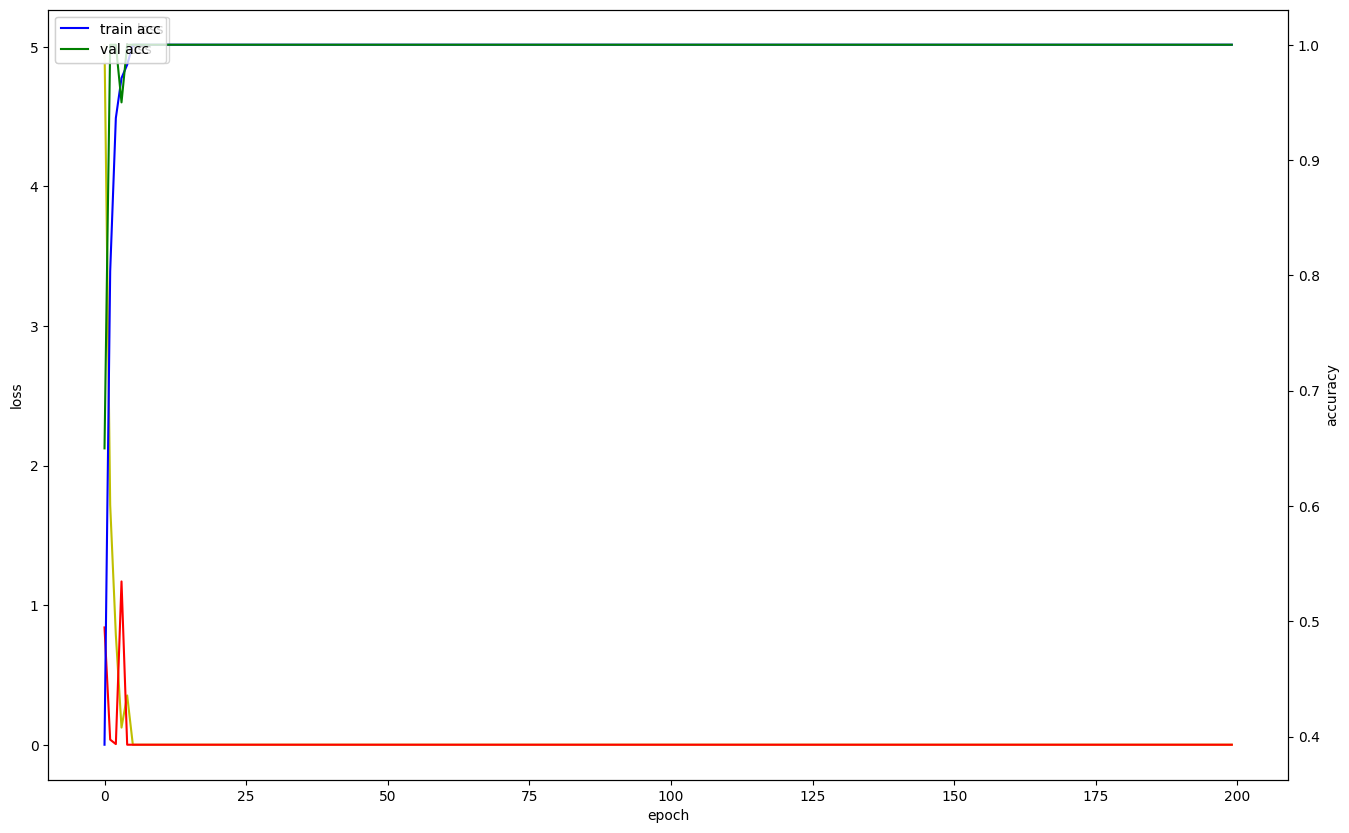

In [9]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [11]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model2_1.1.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

8/8 [==============================] - 0s 5ms/step


array([[[168,   1],
        [  0,  80]],

       [[163,   0],
        [  2,  84]],

       [[165,   1],
        [  0,  83]]])